# Stage 2

In [ ]:
!pip install largestinteriorrectangle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup

In [ ]:
# Rectification: PSNR = 30, SSIM = 0.9 (DONE)
# Stereo: RMSE = 3.5 pixels (DONE)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import largestinteriorrectangle as lir

## Rectification (31.58/0.92)

In [ ]:
def psnr_ssim_rect(orig_img, rectified_img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(rectified_img, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a binary image (black and white)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    grid = thresh.astype(np.bool)

    rectangle = lir.lir(grid)
    
    (x_min, y_min) = lir.pt1(rectangle)
    (x_max, y_max) = lir.pt2(rectangle)

    # Crop the image using the inscribed rectangle's coordinates
    cropped_img = orig_img[y_min:y_max, x_min:x_max]
    cropped_img_rect = rectified_img[y_min:y_max, x_min:x_max]
    
    psnr_out = psnr(cropped_img, cropped_img_rect)
    ssim_out = ssim(cropped_img, cropped_img_rect, multichannel=True)

    return (psnr_out, ssim_out)

In [ ]:
warped_files = natsorted(glob("/content/drive/MyDrive/188/stage2_project_data/stage2_rectification/warped_imgs/*"))
clean_files = natsorted(glob("/content/drive/MyDrive/188/stage2_project_data/stage2_rectification/input_imgs/*"))
print(len(warped_files))
print(len(clean_files))

11
11


In [ ]:
fixed_imgs = []
psnr_sum = 0
ssim_sum = 0

for warped_file, clean_file in tqdm(zip(warped_files, clean_files)):
  img = np.array(Image.open(clean_file))
  warped_img = np.array(Image.open(warped_file))

  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray_warped_img = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)

  sift = cv2.SIFT_create()

  kp_input, descriptors_input = sift.detectAndCompute(gray_img, None)
  kp_warped, descriptors_warped = sift.detectAndCompute(gray_warped_img, None)

  bf = cv2.BFMatcher()
  matches = bf.knnMatch(descriptors_input, descriptors_warped, k=2) 

  good_matches = []
  for m,n in matches:
    if m.distance < 0.999*n.distance:
        good_matches.append(m)

  print(len(good_matches))

  # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

  src_pts = np.float32([ kp_input[good_match.queryIdx].pt for good_match in good_matches ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp_warped[good_match.trainIdx].pt for good_match in good_matches ]).reshape(-1,1,2)

  # Find homography from input image to warped image using RANSAC
  homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
  matchesMask = mask.ravel().tolist()

  # Find the inverse of the homography to convert warped image back to input
  inverse_homography = np.linalg.inv(homography)
  fixed_image = cv2.warpPerspective(warped_img, inverse_homography, (img.shape[1], img.shape[0]))
  fixed_imgs.append(fixed_image)

  # Calculate PSNR/SSIM
  psnr_out, ssim_out = psnr_ssim_rect(img, fixed_image)
  psnr_sum += psnr_out
  ssim_sum += ssim_out

print(psnr_sum/11.0)
print(ssim_sum/11.0)

0it [00:00, ?it/s]

5620
6758
5827
6509
5846
6314
6255
6528
8003
8403
9005
31.58443351773548
0.9202788979806106


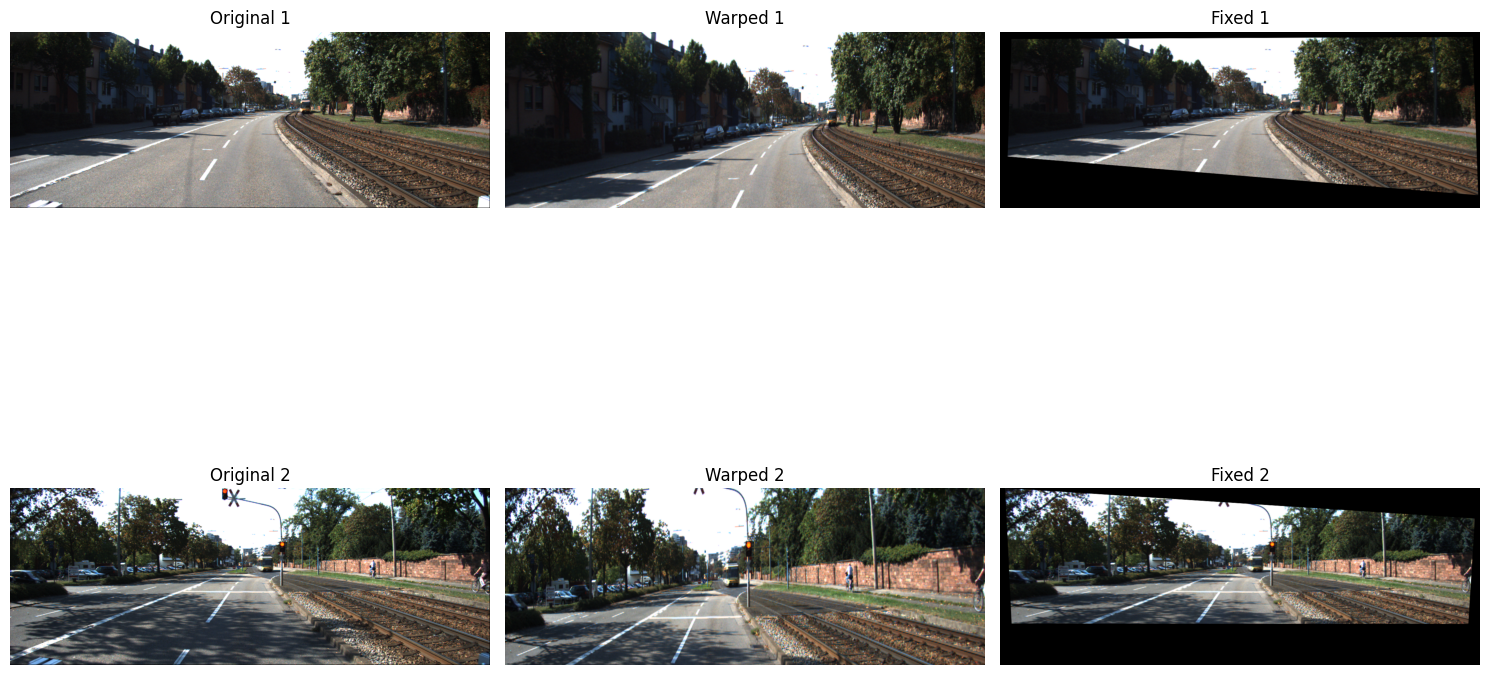

In [ ]:
fig = plt.figure(figsize=(15, 12))
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(np.array(Image.open(clean_files[0])))
plt.axis('off')
plt.title("Original 1")

fig.add_subplot(rows, columns, 2)
plt.imshow(np.array(Image.open(warped_files[0])))
plt.axis('off')
plt.title("Warped 1")

fig.add_subplot(rows, columns, 3)
plt.imshow(fixed_imgs[0])
plt.axis('off')
plt.title("Fixed 1")

fig.add_subplot(rows, columns, 4)
plt.imshow(np.array(Image.open(clean_files[-1])))
plt.axis('off')
plt.title("Original 2")

fig.add_subplot(rows, columns, 5)
plt.imshow(np.array(Image.open(warped_files[-1])))
plt.axis('off')
plt.title("Warped 2")

fig.add_subplot(rows, columns, 6)
plt.imshow(fixed_imgs[-1])
plt.axis('off')
plt.title("Fixed 2")

fig.tight_layout()

## Stereo (2.18)

In [ ]:
left_files = natsorted(glob("/content/drive/MyDrive/188/stage2_project_data/stage2_stereo/left_imgs/*"))
right_files = natsorted(glob("/content/drive/MyDrive/188/stage2_project_data/stage2_stereo/right_imgs/*"))
disparities = natsorted(glob("/content/drive/MyDrive/188/stage2_project_data/stage2_stereo/disparities/*"))

print(len(left_files))
print(len(right_files))
print(len(disparities))

5
5
5


In [ ]:
# Parameter tuning - tuned multiple times with values adjusted based on previous trial to generate the best RMSE possible.
max_disparities = [64, 80, 96, 112, 128]
block_sizes = [3, 5, 7, 11, 13]
unique_ratios = [15, 20, 25, 30, 35]
speckle_window_sizes = [200, 250, 300, 350, 400]

rmse_sum = 0

for left_file, right_file, disparity in tqdm(zip(left_files, right_files, disparities)):
  left_img = cv2.imread(left_file, 0)
  right_img = cv2.imread(right_file, 0)
  disp_gt_img = cv2.imread(disparity, 0).astype(np.float32)

  min_rmse = 1000
  best_disparity = -1
  best_block_size = -1
  best_unique_ratio = -1
  best_speckle_window_size = -1

  for max_disparity in max_disparities:
    for block_size in block_sizes:
      for unique_ratio in unique_ratios:
        for speckle_window_size in speckle_window_sizes:
            stereo = cv2.StereoSGBM_create(
                numDisparities = max_disparity,
                blockSize = block_size,
                P1 = 8*block_size*block_size,
                P2 = 32*block_size*block_size,
                uniquenessRatio = unique_ratio,
                speckleWindowSize = speckle_window_size,
                speckleRange = 1
            )
            
            predicted_disp = stereo.compute(left_img, right_img)
            predicted_disp = cv2.normalize(predicted_disp, None, alpha = 0, beta = max_disparity, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

            # Error
            mask = np.logical_or(predicted_disp == 0, disp_gt_img == 0)
            masked_sq_error = np.ma.array(np.square(predicted_disp - disp_gt_img), mask = mask)
            rmse = np.sqrt(masked_sq_error.mean())

            if (rmse < min_rmse):
              min_rmse = rmse
              best_disparity = max_disparity
              best_block_size = block_size
              best_unique_ratio = unique_ratio
              best_speckle_window_size = speckle_window_size
              
  print("Best disparity: " + str(best_disparity))
  print("Best block size: " + str(best_block_size))
  print("Best unique ratio: " + str(best_unique_ratio))
  print("Best speckle window size: " + str(best_speckle_window_size))
  print("RMSE: " + str(min_rmse))
  print("")

  rmse_sum += min_rmse

print("Average RMSE: " + str(rmse_sum/5.0))

0it [00:00, ?it/s]

Best disparity: 96
Best block size: 3
Best unique ratio: 35
Best speckle window size: 400
RMSE: 1.8218098896607113

Best disparity: 64
Best block size: 3
Best unique ratio: 35
Best speckle window size: 350
RMSE: 1.7320436624871665

Best disparity: 64
Best block size: 5
Best unique ratio: 35
Best speckle window size: 200
RMSE: 1.7114308550621071

Best disparity: 80
Best block size: 3
Best unique ratio: 35
Best speckle window size: 400
RMSE: 2.8350903095698987

Best disparity: 64
Best block size: 3
Best unique ratio: 35
Best speckle window size: 250
RMSE: 2.790424905490664

Average RMSE: 2.1781599244541097
